In [1]:
library(DESeq2)
library(enrichplot)
library(clusterProfiler)
library(ggplot2)
library(tidyr)
library(dplyr)
library(ggrepel)  # For non-overlapping text labels
library(org.Hs.eg.db)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [2]:
deseq_brain = readRDS('../../rds/deseq2_brain_mockvirus.rds')
deseq_gundiff = readRDS('../../rds/deseq2_gut_undiff_mockvirus.rds')
deseq_gdiff = readRDS('../../rds/deseq2_gut_diff_mockvirus.rds')
genes = read.csv('../../output/gut/gut_genes.csv',row.names = 1)

In [3]:
plotPair1 <- function(xcnd, ycnd, xlab, ylab, title, sgnby = "x", gene_names = genes, top_n = 50) {
  cmn <- intersect(rownames(xcnd), rownames(ycnd))
  plot_df <- data.frame(
    gene_id = cmn,
    x = xcnd[cmn, "log2FoldChange"],
    y = ycnd[cmn, "log2FoldChange"],
    xpadj = xcnd[cmn, "padj"],
    ypadj = ycnd[cmn, "padj"]
  )
  
  plot_df$gene_name <- gene_names[plot_df$gene_id, "gene_name"]
  
  # Significance by selected direction (x/y/xy)
  plot_df$significant <- rowSums(
    plot_df[, paste0(strsplit(sgnby, "")[[1]], "padj"), drop = FALSE] < 0.05
  ) == nchar(sgnby)
  plot_df$significant[is.na(plot_df$significant)] <- FALSE

  # Filter strongly regulated & significant genes for labeling
  label_df <- plot_df %>%
    filter(significant & abs(x) > 2 & abs(y) > 2) %>%
    arrange((xpadj + ypadj)/2) %>%   # Average padj to rank by significance
    head(top_n)

  # Set labels
  plot_df$label <- ifelse(plot_df$gene_id %in% label_df$gene_id, plot_df$gene_name, "")

  # Create plot
  p <- ggplot(plot_df, aes(x = x, y = y)) +
    geom_point(aes(shape = significant), size = 2) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "red") +
    geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
    geom_text_repel(aes(label = label), size = 3.5, color = "blue", max.overlaps = Inf) +
    theme_minimal() +
    labs(title = title, x = xlab, y = ylab) +
    theme(legend.position = "none")

  return(p)
}


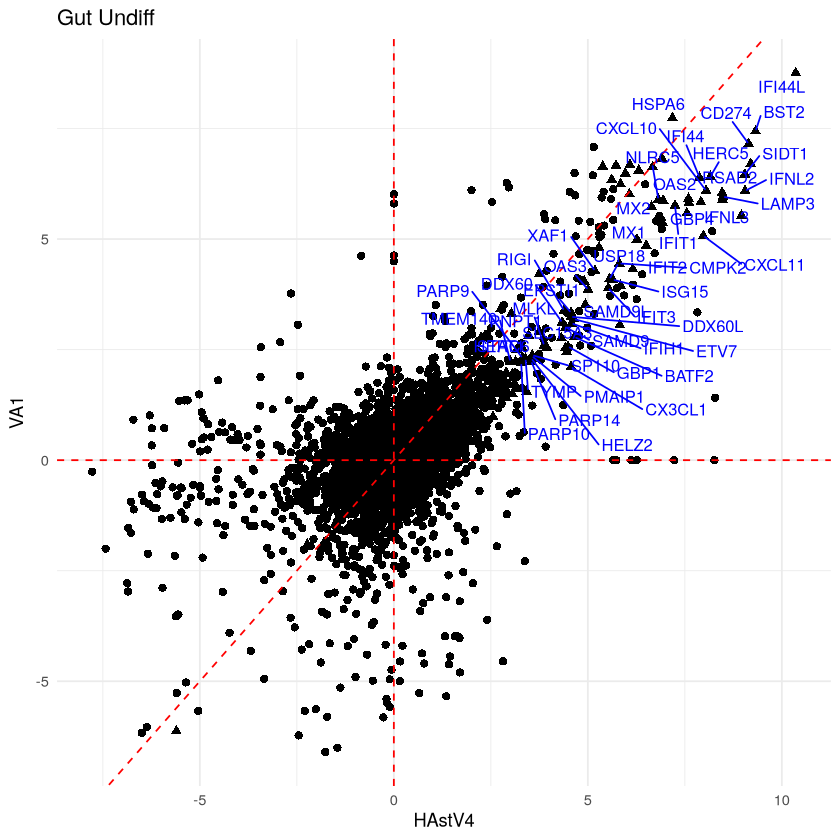

In [8]:
p = plotPair1(xcnd = deseq_gundiff$HAstV4,
             ycnd = deseq_gundiff$VA1,
             xlab = "HAstV4", ylab = "VA1",
             title = "Gut Undiff",
             sgnby = 'xy',
             top_n = 50)
p
# Save wide plot if needed
ggsave("plotpair_top50_Gundiff_HAstV4_vs_VA1.png", p, width = 10, height = 8, dpi = 300)
